# Random Forest Model (Preprocessing)

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter


from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#LOAD DATASET (data is already cleaned from notebook.ipynb)
song_df = pd.read_csv("processed_song_data.csv")

song_df.head()

,Track Name,Artist Name(s),Album Name,Album Artist Name(s),Explicit,age,artist_name,dating,family/gospel,genre,...,feelings,light/visual_perceptions,like/girls,movement/places,music,obscene,sadness,shake_the_audience,mood_%,mood
0,Justified & Ancient - Stand by the Jams,The KLF,Songs Collection,The KLF,False,1.0,mukesh,0.000598,0.048857,pop,...,0.117175,0.000598,0.000598,0.000598,0.039288,0.000598,0.380299,0.000598,0.426354,Neutral
1,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,Pitbull,False,1.0,'frankie laine',0.035537,0.027007,pop,...,0.001284,0.212681,0.001284,0.001284,0.118034,0.001284,0.001284,0.001284,0.770510,High Emotion
2,From the Bottom of My Broken Heart,Britney Spears,...Baby One More Time (Digital Deluxe Version),Britney Spears,False,1.0,'johnnie ray',0.002770,0.002770,pop,...,0.225422,0.002770,0.002770,0.002770,0.323794,0.002770,0.002770,0.002770,0.683601,High Emotion
3,Apeman - 2014 Remastered Version,The Kinks,"Lola vs. Powerman and the Moneygoround, Pt. On...",The Kinks,False,1.0,'prez prado',0.048249,0.001548,pop,...,0.001548,0.001548,0.081132,0.129250,0.001548,0.001548,0.225889,0.021500,0.604193,High Emotion
4,You Can't Always Get What You Want,The Rolling Stones,Let It Bleed,The Rolling Stones,False,1.0,'giorgos papadopoulos',0.001350,0.001350,pop,...,0.001350,0.001350,0.001350,0.001350,0.001350,0.001350,0.068800,0.001350,0.523334,Neutral


In [3]:
# Step 4: Feature Extraction
# split data into features and labels.
song_X = song_df.drop(columns=[
    # these are y variables
    'mood', 'mood_%',
    # these are too specific and may lead to overfitting
    'Track Name', 'Artist Name(s)', 'Album Name', 'Album Artist Name(s)', 'artist_name', 'track_name',
    # these are directly used to calculate mood, so to prevent data leakage we will drop them
    "Energy", "Valence", "sadness"
])

song_y = song_df['mood']

In [4]:
# encode labels

# Select categorical columns
categorical_columns = ["genre", "topic"]
categorical_features = song_X[categorical_columns]

# OneHotEncode categorical features
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='error')
onehot_encoded_features = onehot_encoder.fit_transform(categorical_features)

one_hot_encoded_df = pd.DataFrame(onehot_encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_columns))

one_hot_encoded_df.head()

,genre_blues,genre_country,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
# Scale numerical features with Robust Scaler to prevent outliers
# Select numerical columns
numerical_columns = song_X.drop(columns=categorical_columns)

# scale features
robust_scaler = RobustScaler()
scaled_numerical_song_X = robust_scaler.fit_transform(numerical_columns)

# add scaled features back to dataset
song_df_scaled = pd.DataFrame(scaled_numerical_song_X, columns=numerical_columns.columns)

song_df_scaled.head()

,Explicit,age,dating,family/gospel,night/time,romantic,violence,world/life,Danceability,Key,...,Tempo,communication,family/spirtual,feelings,light/visual_perceptions,like/girls,movement/places,music,obscene,shake_the_audience
0,0.0,1.354839,-0.304616,13.753176,-0.020203,0.388631,0.325838,-0.021807,0.009088,2.831565,...,-10.050823,2.019382,-0.046505,3.715431,-0.020727,-0.036869,-0.021489,0.651982,-0.012583,-0.083452
1,0.0,1.354839,12.015053,7.412837,-0.009395,-0.010446,0.501583,2.284810,0.217088,-3.168435,...,5.536177,-0.010424,2.090158,-0.015152,3.409123,-0.011510,-0.008092,2.022035,-0.005493,-0.026053
2,0.0,1.354839,0.461240,0.379585,0.014036,3.956966,0.001404,-0.010494,0.069088,1.831565,...,-46.527823,1.918204,0.045345,7.199923,0.014399,0.043467,0.020954,5.601954,0.009878,0.098386
3,0.0,1.354839,16.497359,0.024956,-0.005229,10.338176,-0.005099,-0.016859,0.075088,3.831565,...,-46.197823,-0.008380,-0.006335,-0.006644,-0.005364,2.941837,2.492491,-0.004644,-0.002760,1.666475
4,0.0,1.354839,-0.039654,-0.032634,-0.008358,11.647211,-0.006155,2.151139,-0.288912,-5.168435,...,-35.690823,-0.009915,1.186473,-0.013032,-0.008574,-0.009075,-0.006805,-0.008096,-0.004812,-0.020542


In [6]:
# combine scaled numerical features and onehot encoded features
processed_song_X = pd.concat([song_df_scaled, one_hot_encoded_df], axis=1)
print(processed_song_X.shape)
processed_song_X.head()

(27866, 38)


,Explicit,age,dating,family/gospel,night/time,romantic,violence,world/life,Danceability,Key,...,genre_pop,genre_reggae,genre_rock,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life
0,0.0,1.354839,-0.304616,13.753176,-0.020203,0.388631,0.325838,-0.021807,0.009088,2.831565,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.354839,12.015053,7.412837,-0.009395,-0.010446,0.501583,2.284810,0.217088,-3.168435,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.354839,0.461240,0.379585,0.014036,3.956966,0.001404,-0.010494,0.069088,1.831565,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.354839,16.497359,0.024956,-0.005229,10.338176,-0.005099,-0.016859,0.075088,3.831565,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.354839,-0.039654,-0.032634,-0.008358,11.647211,-0.006155,2.151139,-0.288912,-5.168435,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
# Split the dataset into training (60%), validation (20%), and test (20%) sets

X_train, X_test, y_train, y_test = train_test_split(processed_song_X, song_y, test_size=0.2, random_state=42, stratify=song_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Random Forest(Default)

In [8]:

# create random forest model with default parameters
random_forest_model = RandomForestClassifier(random_state=42)

# Train the Default Random Forest Model
random_forest_model.fit(X_train, y_train)


# predict on test set
random_forest_model_pred = random_forest_model.predict(X_test)


In [9]:
# evaluate model performance on validation set
random_forest_model_eval = random_forest_model.score(X_val, y_val)
print(f"Random Forest Model Default Performance on Validation Set: {random_forest_model_eval}")

Random Forest Model Default Performance on Validation Set: 0.7263592320114839


In [10]:
# print classification report before tuning hyperparameters
print("Classification Report (Before Tuning Hyperparameters):")
print(classification_report(y_test, random_forest_model_pred))

Classification Report (Before Tuning Hyperparameters):
              precision    recall  f1-score   support

High Emotion       0.73      0.93      0.82      2932
 Low Emotion       0.78      0.25      0.38       373
     Neutral       0.73      0.55      0.63      2269

    accuracy                           0.73      5574
   macro avg       0.75      0.58      0.61      5574
weighted avg       0.73      0.73      0.71      5574



In [11]:
# list top 10 features importance
feature_importance = dict(zip(processed_song_X.columns, random_forest_model.feature_importances_))
top_10_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]

print("Random Forest Model Default Top 10 Features Importance:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance}")

Random Forest Model Default Top 10 Features Importance:
topic_sadness: 0.14719026946394503
obscene: 0.045320918355285525
world/life: 0.0450094628564646
violence: 0.042999109531171566
communication: 0.04078310493891406
music: 0.03918011290231481
age: 0.03870383401797712
light/visual_perceptions: 0.038154342360549154
night/time: 0.03778503741731862
romantic: 0.03721547550799813


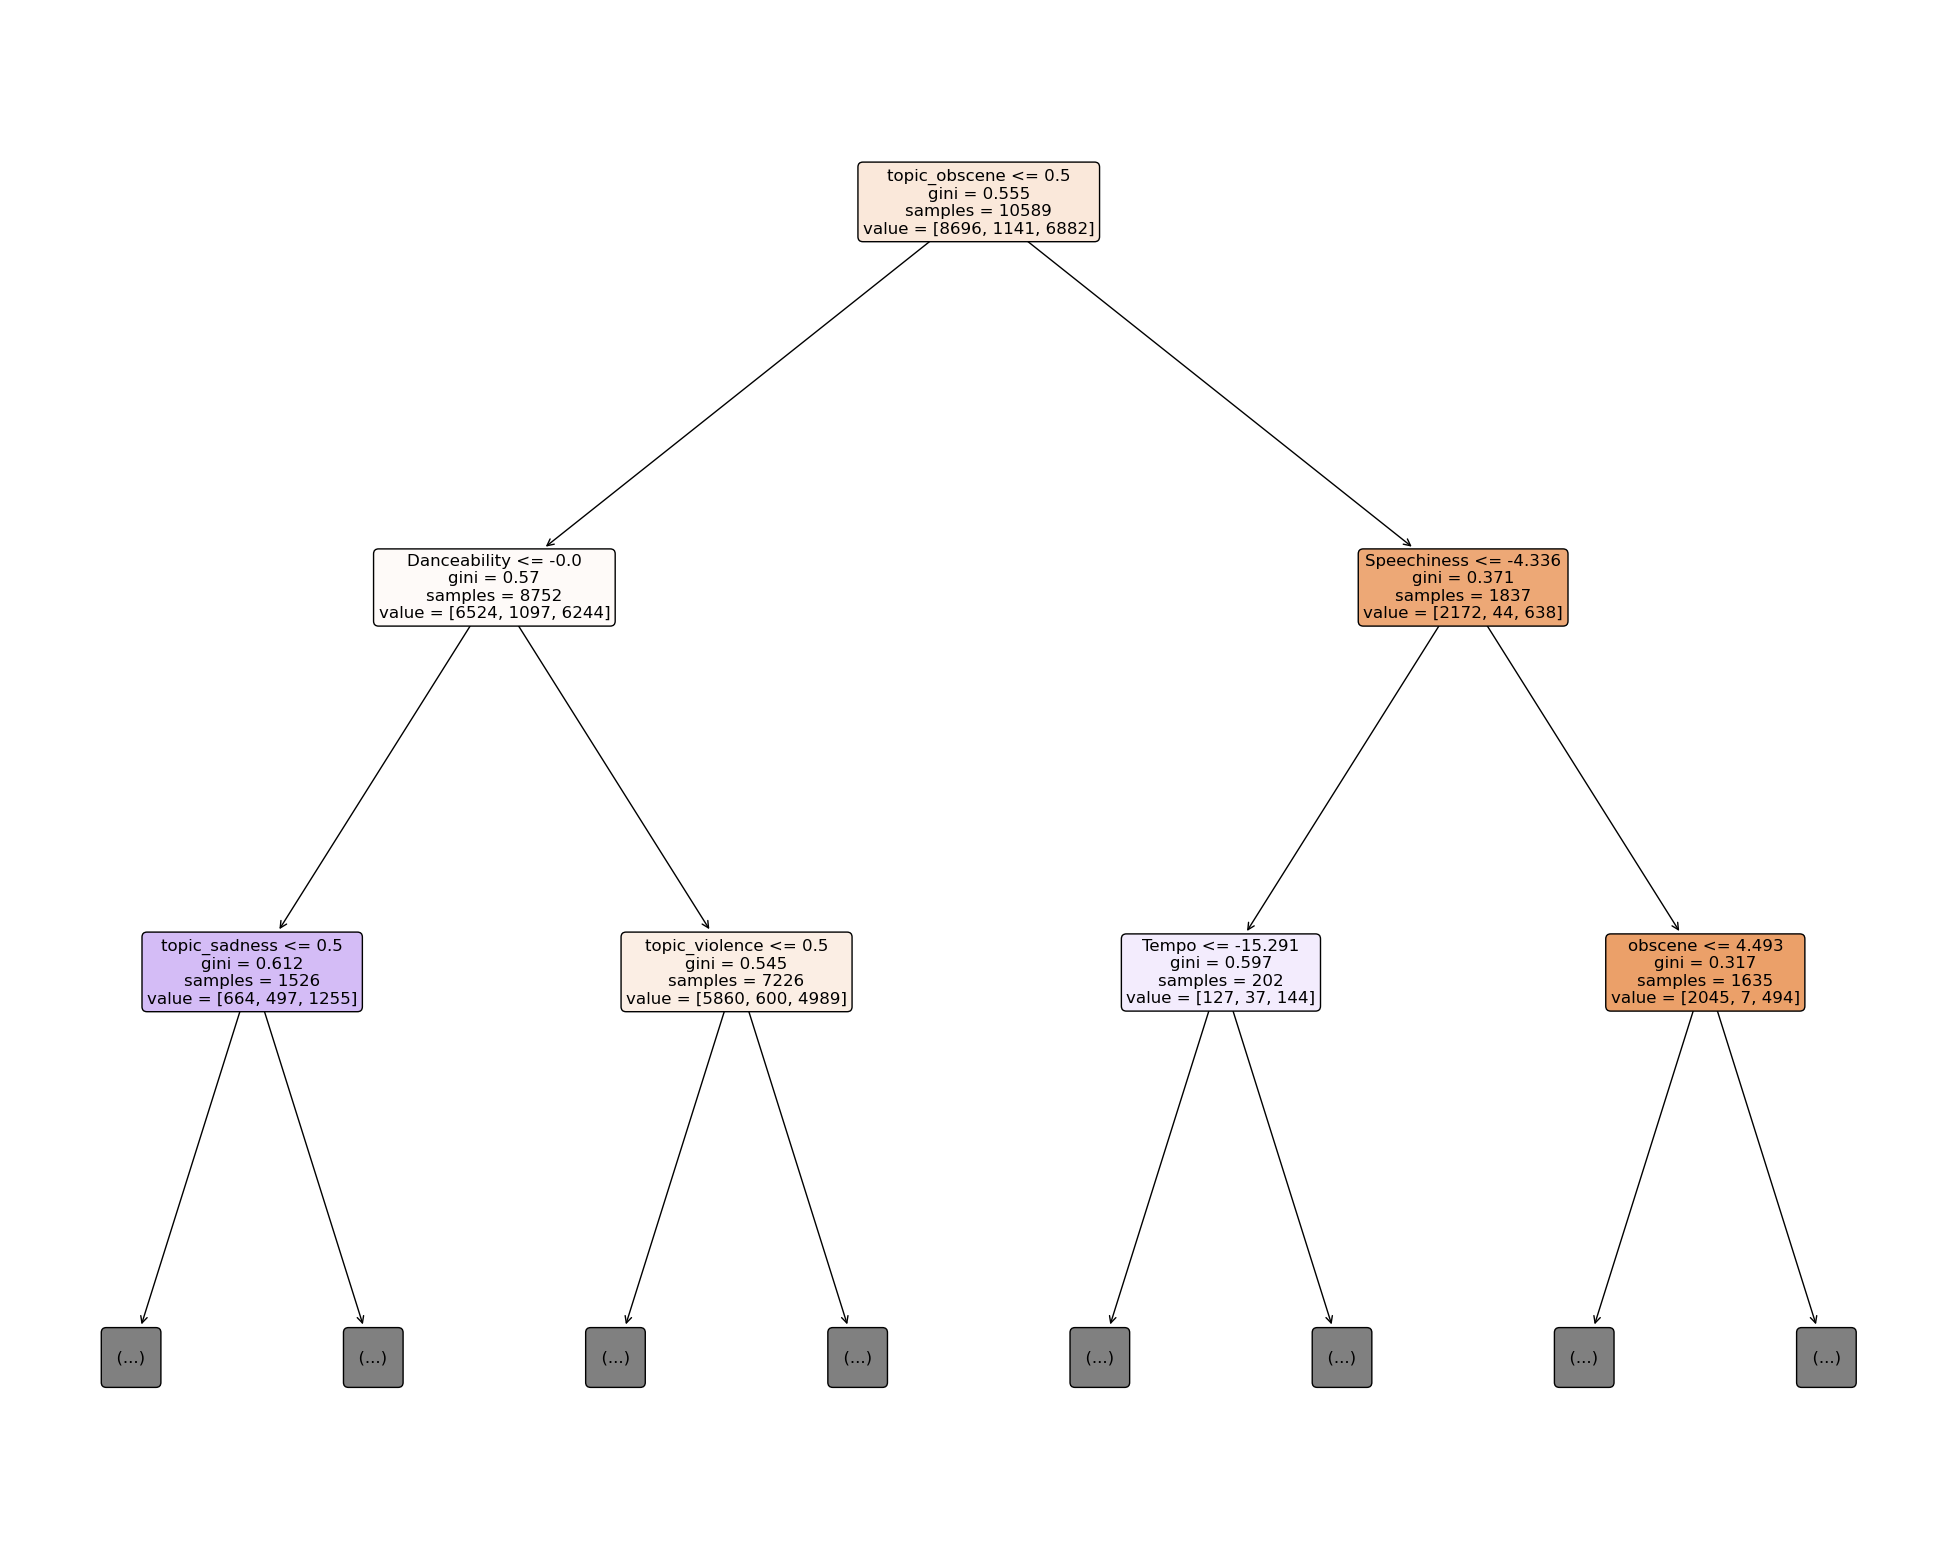

In [12]:

# display random forest model tree with max depth = 2
plt.figure(figsize=(25, 20))
plot_tree(random_forest_model.estimators_[0],max_depth=2, feature_names=processed_song_X.columns, filled=True, rounded=True)
plt.show()

#### Optimze Default Random Forest Model

In [13]:
# Tune hyperparameters with random search and record best score
# define parameter grid to search
# using random search because of large dataset
# random search over n_estimators, max_depth, min_samples_split, min_samples_leaf 
param_grid = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create random search object
search_random_forest_model = RandomForestClassifier(random_state=42)

"""
Note using StratifiedKFold with 3 folds and scoring = 'f1_weighted' due to imbalanced dataset
"""

# perform random search
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_random_search = RandomizedSearchCV(search_random_forest_model, param_distributions=param_grid, cv=stratified_cv, scoring='f1_weighted')
rf_random_search.fit(X_train, y_train)

# print grid search results
print("Default Random Forest Model Best Parameters:", rf_random_search.best_params_)


Default Random Forest Model Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}


In [14]:
# train random forest model with best parameters
best_n_estimators = rf_random_search.best_params_['n_estimators']
best_max_depth = rf_random_search.best_params_['max_depth']
best_min_samples_split = rf_random_search.best_params_['min_samples_split']
best_min_samples_leaf = rf_random_search.best_params_['min_samples_leaf']

optimal_random_forest_model = (RandomForestClassifier(n_estimators=best_n_estimators, 
                                                     max_depth=best_max_depth, 
                                                     min_samples_split=best_min_samples_split, 
                                                     min_samples_leaf=best_min_samples_leaf, 
                                                     random_state=42))

# Train the Optimized Random Forest Model
optimal_random_forest_model.fit(X_train, y_train)

# predict on test set
optimal_random_forest_model_pred = optimal_random_forest_model.predict(X_test)

# evaluate model performance on test set with validation set
optimal_random_forest_model_eval = optimal_random_forest_model.score(X_val, y_val)

print(f"Optimized Random Forest Model Performance on Validation Set: {optimal_random_forest_model_eval} \n")

# print classification report after tuning hyperparameters
print("Classification Report after Tuning Hyperparameters:")
print(classification_report(y_test, optimal_random_forest_model_pred))

Optimized Random Forest Model Performance on Validation Set: 0.7213350080746456 

Classification Report after Tuning Hyperparameters:
              precision    recall  f1-score   support

High Emotion       0.73      0.95      0.83      2932
 Low Emotion       0.76      0.19      0.30       373
     Neutral       0.73      0.54      0.62      2269

    accuracy                           0.73      5574
   macro avg       0.74      0.56      0.58      5574
weighted avg       0.73      0.73      0.71      5574



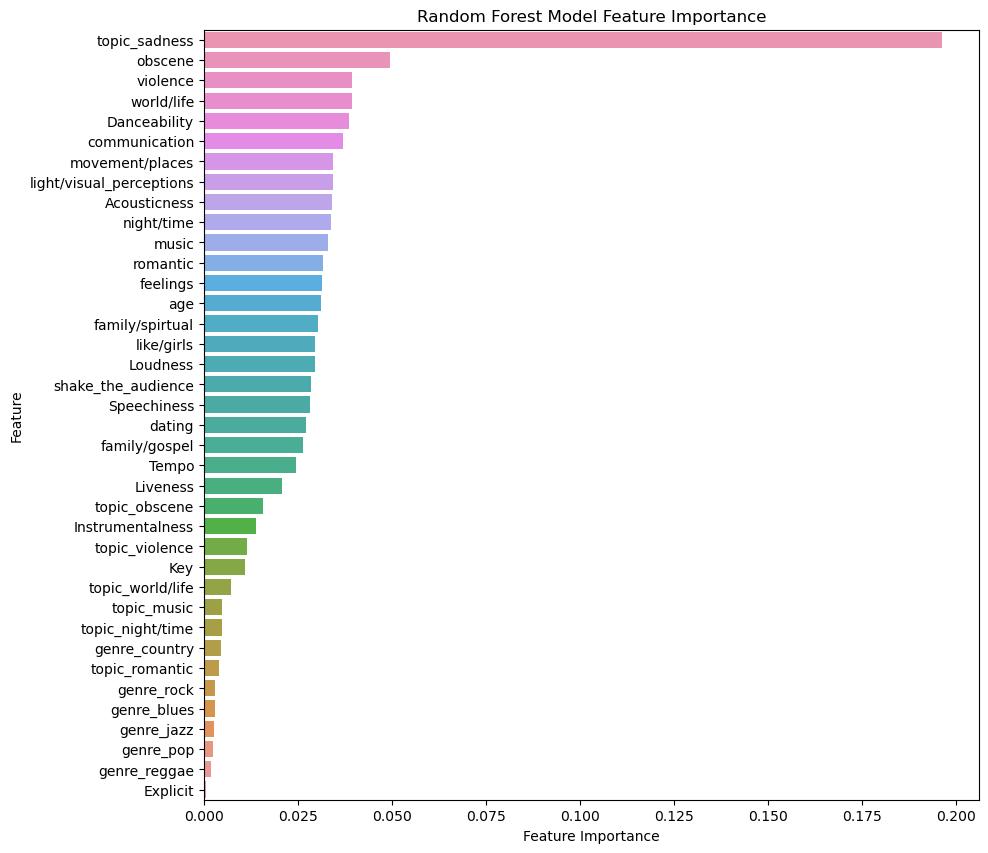

In [15]:
# Examine feature importance for random forest model

# create dataframe of feature importance
feature_importance_df = pd.DataFrame({"feature": processed_song_X.columns, "importance": optimal_random_forest_model.feature_importances_})

# sort dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=feature_importance_df, x="importance", y="feature", ax=ax, hue="importance", dodge=False)
ax.set_title("Random Forest Model Feature Importance")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature")
ax.get_legend().remove()
plt.show()

## Confusion Matrix for Default and Optimize Random Forest

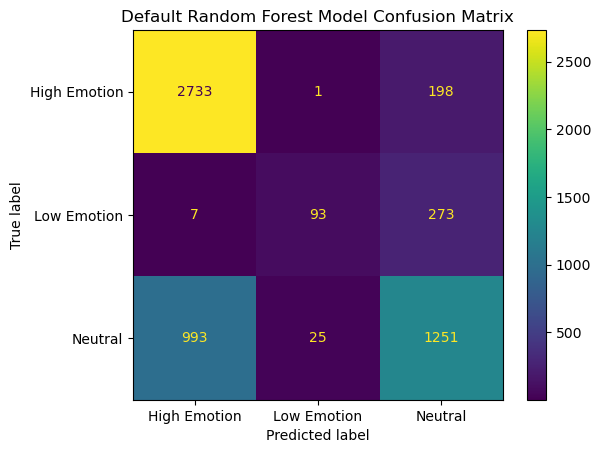

In [16]:
# confusion matrix for default random forest model
cm1 = confusion_matrix(y_test, random_forest_model_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=random_forest_model.classes_)

# plot confusion matrix

disp1.plot(values_format='')
plt.title("Default Random Forest Model Confusion Matrix")
plt.show()

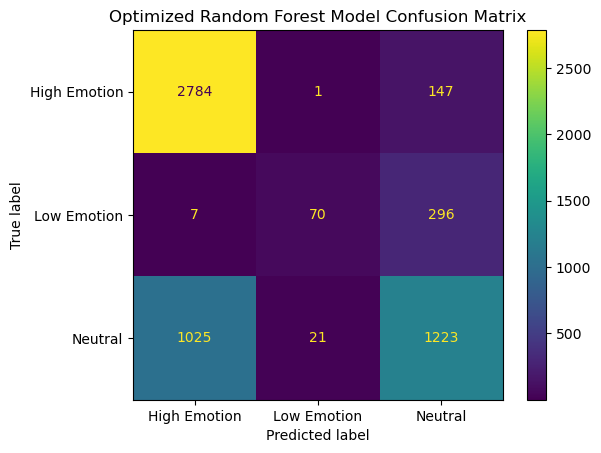

In [17]:
# visualize confusion matrix for optimized random forest model
cm2 = confusion_matrix(y_test, optimal_random_forest_model_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=optimal_random_forest_model.classes_)

# plot confusion matrix
disp2.plot(values_format='')
plt.title("Optimized Random Forest Model Confusion Matrix")
plt.show()

# Random Forest(Undersampling)

In [18]:
# perform random under sampling
rus = RandomUnderSampler(random_state=42)

# resample training data
emotion_X_train, emotion_y_train = rus.fit_resample(X_train, y_train)

In [20]:
# train random forest model with best parameters
rus_random_forest_model = (RandomForestClassifier(n_estimators=best_n_estimators,
                                                 max_depth=best_max_depth,
                                                 min_samples_split=best_min_samples_split,
                                                 min_samples_leaf=best_min_samples_leaf,
                                                 random_state=42))

# Train the Random Forest Model
rus_random_forest_model.fit(emotion_X_train, emotion_y_train)

# predict on test set

rus_random_forest_model_pred = rus_random_forest_model.predict(X_test)

# evaluate model performance on test set with validation set

rus_random_forest_model_eval = rus_random_forest_model.score(X_val, y_val)

print(f"Random Undersampling Random Forest Model Performance on Validation Set: {rus_random_forest_model_eval} \n")

# print classification report after tuning hyperparameters
print(" Random Under Sampling Classification Report :")
print(classification_report(y_test, rus_random_forest_model_pred))

Random Undersampling Random Forest Model Performance on Validation Set: 0.6296429212273461 

 Random Under Sampling Classification Report :
              precision    recall  f1-score   support

High Emotion       0.75      0.84      0.79      2932
 Low Emotion       0.31      0.93      0.47       373
     Neutral       0.62      0.32      0.42      2269

    accuracy                           0.63      5574
   macro avg       0.56      0.70      0.56      5574
weighted avg       0.67      0.63      0.62      5574



## Confusion Matrix for UnderSampling


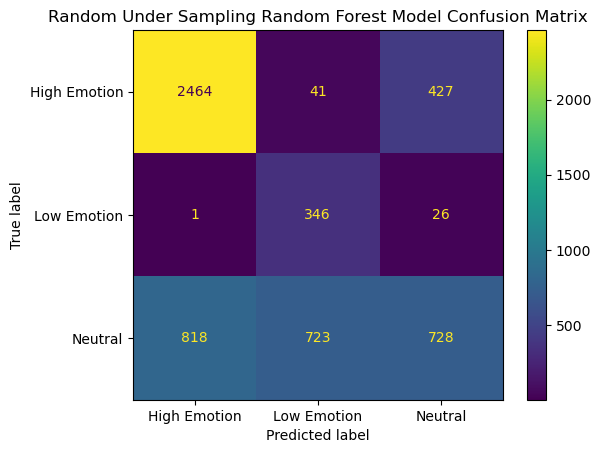

In [21]:
# confusion matrix for under sampling random forest model
cm3 = confusion_matrix(y_test, rus_random_forest_model_pred)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=rus_random_forest_model.classes_)

# plot confusion matrix

disp3.plot(values_format='')
plt.title("Random Under Sampling Random Forest Model Confusion Matrix")
plt.show()

# Random Forest (OverSampling)

In [22]:
# perform random over sampling
ros = RandomOverSampler(random_state=42)

# resample training data
emotion_X_train_ros, emotion_y_train_ros = ros.fit_resample(X_train, y_train)

In [23]:
# train over sample random forest model with best parameters

oversample_random_forest_model = (RandomForestClassifier(n_estimators=best_n_estimators,
                                                        max_depth=best_max_depth,
                                                        min_samples_split=best_min_samples_split,
                                                        min_samples_leaf=best_min_samples_leaf,
                                                        random_state=42))

# Train the Random Forest Model
oversample_random_forest_model.fit(emotion_X_train_ros, emotion_y_train_ros)

# predict on test set

oversample_random_forest_model_pred = oversample_random_forest_model.predict(X_test)

# evaluate model performance on test set with validation set

oversample_random_forest_model_eval = oversample_random_forest_model.score(X_val, y_val)

print(f"Oversampling Random Forest Model Performance on Validation Set: {oversample_random_forest_model_eval} \n")

# print classification report after tuning hyperparameters

print(" Random Over Sampling Classification Report :")

print(classification_report(y_test, oversample_random_forest_model_pred))


Oversampling Random Forest Model Performance on Validation Set: 0.7299479633949398 

 Random Over Sampling Classification Report :
              precision    recall  f1-score   support

High Emotion       0.74      0.93      0.82      2932
 Low Emotion       0.60      0.50      0.54       373
     Neutral       0.75      0.53      0.62      2269

    accuracy                           0.74      5574
   macro avg       0.70      0.65      0.66      5574
weighted avg       0.74      0.74      0.72      5574



## Confusion Matrix for UnderSampling

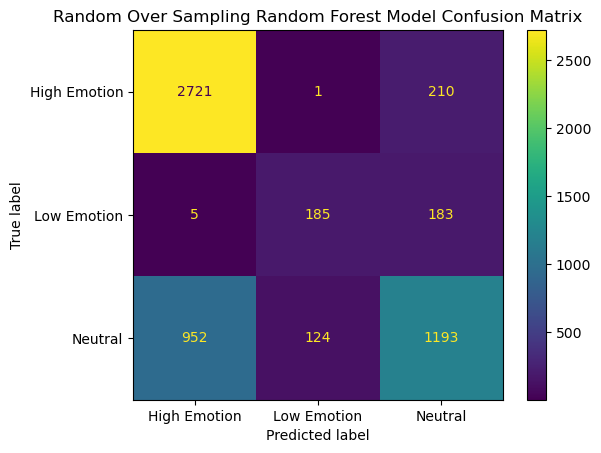

In [24]:
# confusion matrix for over sampling random forest model
cm4 = confusion_matrix(y_test, oversample_random_forest_model_pred)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=oversample_random_forest_model.classes_)

# plot confusion matrix

disp4.plot(values_format='')
plt.title("Random Over Sampling Random Forest Model Confusion Matrix")
plt.show()

# Random Forest (SMOTE)

In [25]:
# Custom sampling strategy: Only oversample 'Low Emotion' class
sampling_strategy = {'Low Emotion': int(Counter(y_train)['Neutral']), 'High Emotion': Counter(y_train)['High Emotion'], 'Neutral': Counter(y_train)['Neutral']}

#perform SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# resample training data
emotion_X_train_smote, emotion_y_train_smote = smote.fit_resample(X_train, y_train)

In [26]:
# train smote random forest model with best parameters

smote_random_forest_model = (RandomForestClassifier(n_estimators=best_n_estimators,
                                                    max_depth=best_max_depth,
                                                    min_samples_split=best_min_samples_split,
                                                    min_samples_leaf=best_min_samples_leaf,
                                                    random_state=42))

# Train the Random Forest Model
smote_random_forest_model.fit(emotion_X_train_smote, emotion_y_train_smote)

# predict on test set

smote_random_forest_model_pred = smote_random_forest_model.predict(X_test)

# evaluate model performance on test set with validation set

smote_random_forest_model_eval = smote_random_forest_model.score(X_val, y_val)

print(f"SMOTE Random Forest Model Performance on Validation Set: {smote_random_forest_model_eval} \n")

# print classification report after tuning hyperparameters

print(" SMOTE Classification Report :")

print(classification_report(y_test, smote_random_forest_model_pred))

SMOTE Random Forest Model Performance on Validation Set: 0.7198995155212632 

 SMOTE Classification Report :
              precision    recall  f1-score   support

High Emotion       0.73      0.95      0.82      2932
 Low Emotion       0.53      0.50      0.51       373
     Neutral       0.77      0.47      0.58      2269

    accuracy                           0.72      5574
   macro avg       0.67      0.64      0.64      5574
weighted avg       0.73      0.72      0.70      5574



## Confusion Matrix for SMOTE

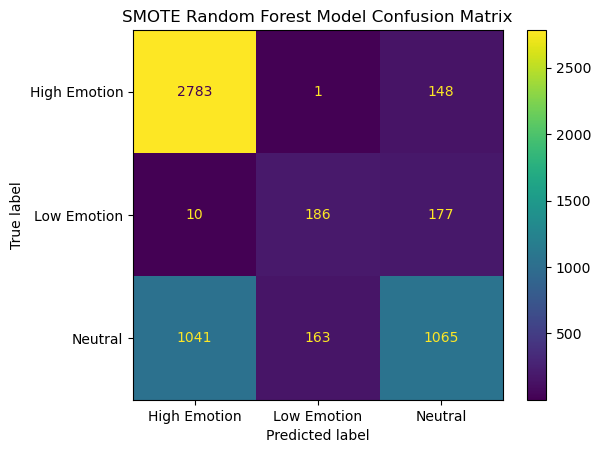

In [27]:
# confusion matrix for smote random forest model

cm5 = confusion_matrix(y_test, smote_random_forest_model_pred)
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=smote_random_forest_model.classes_)

# plot confusion matrix

disp5.plot(values_format='')
plt.title("SMOTE Random Forest Model Confusion Matrix")
plt.show()